<a id="100"></a>
<h2 style='background:#FBE338; border:0; color:black'><center>Example Using The kaggle_environments For Testing Agents<center><h2>

We need to import the library for creating environments and simulating agent battles

In [1]:
# Upgrade kaggle_environments using pip before import
!pip install -q -U kaggle_environments

     |████████████████████████████████| 102kB 3.7MB/s 
     |████████████████████████████████| 61kB 7.3MB/s 
ERROR: nbclient 0.5.1 has requirement jupyter-client>=6.1.5, but you'll have jupyter-client 5.3.5 which is incompatible.


In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from kaggle_environments import make, evaluate, utils

Loading environment football failed: No module named 'gfootball'


Create a rock-paper-scissors environment (RPS), and set 1000 episodes for each simulation

In [3]:
env = make("rps", configuration={"episodeSteps": 1000})

In [5]:
import random
from kaggle_environments.envs.rps.utils import get_score

def rock(observation, configuration):
    return 0

def paper(observation, configuration):
    return 1

def scissors(observation, configuration):
    return 2

def copy_opponent(observation, configuration):
    if observation.step > 0:
        return observation.lastOpponentAction
    else:
        return random.randrange(0, configuration.signs)

last_react_action = None

def reactionary(observation, configuration):
    global last_react_action
    if observation.step == 0:
        last_react_action = random.randrange(0, configuration.signs)
    elif get_score(last_react_action, observation.lastOpponentAction) <= 1:
        last_react_action = (observation.lastOpponentAction + 1) % configuration.signs

    return last_react_action

last_counter_action = None

def counter_reactionary(observation, configuration):
    global last_counter_action
    if observation.step == 0:
        last_counter_action = random.randrange(0, configuration.signs)
    elif get_score(last_counter_action, observation.lastOpponentAction) == 1:
        last_counter_action = (last_counter_action + 2) % configuration.signs
    else:
        last_counter_action = (observation.lastOpponentAction + 1) % configuration.signs

    return last_counter_action

action_histogram = {}

def statistical(observation, configuration):
    global action_histogram
    if observation.step == 0:
        action_histogram = {}
        return
    action = observation.lastOpponentAction
    if action not in action_histogram:
        action_histogram[action] = 0
    action_histogram[action] += 1
    mode_action = None
    mode_action_count = None
    for k, v in action_histogram.items():
        if mode_action_count is None or v > mode_action_count:
            mode_action = k
            mode_action_count = v
            continue

    return (mode_action + 1) % configuration.signs

my_last_action = 0

def last_act_attack(observation, configuration):   #hit_the_last_own_action
    global my_last_action
    my_last_action = (my_last_action + 1) % 3 
    return my_last_action

def nash_equilibrium(observation, configuration):
    return random.randint(0, 2)


In [7]:
import collections
import pandas as pd
import numpy as np
import json

def markov_agent(observation, configuration):
    k = 2
    global table, action_seq
    if observation.step % 250 == 0: # refresh table every 250 steps
        action_seq, table = [], collections.defaultdict(lambda: [1, 1, 1])    
    if len(action_seq) <= 2 * k + 1:
        action = int(np.random.randint(3))
        if observation.step > 0:
            action_seq.extend([observation.lastOpponentAction, action])
        else:
            action_seq.append(action)
        return action
    # update table
    key = ''.join([str(a) for a in action_seq[:-1]])
    table[key][observation.lastOpponentAction] += 1
    # update action seq
    action_seq[:-2] = action_seq[2:]
    action_seq[-2] = observation.lastOpponentAction
    # predict opponent next move
    key = ''.join([str(a) for a in action_seq[:-1]])
    if observation.step < 500:
        next_opponent_action_pred = np.argmax(table[key])
    else:
        scores = np.array(table[key])
        next_opponent_action_pred = np.random.choice(3, p=scores/scores.sum()) # add stochasticity for second part of the game
    # make an action
    action = (next_opponent_action_pred + 1) % 3
    # if high probability to lose -> let's surprise our opponent with sudden change of our strategy
    if observation.step > 900:
        action = next_opponent_action_pred
    action_seq[-1] = action
    return int(action)

###############################

# how many steps in a row are in the pattern (multiplied by two)
memory_length = 6
# current memory of the agent
current_memory = []
# list of memory patterns
memory_patterns = []

def find_pattern(memory):
    """ find appropriate pattern in memory """
    for pattern in memory_patterns:
        actions_matched = 0
        for i in range(memory_length):
            if pattern["actions"][i] == memory[i]:
                actions_matched += 1
            else:
                break
        # if memory fits this pattern
        if actions_matched == memory_length:
            return pattern
    # appropriate pattern not found
    return None

def memory_patterns(obs, conf):
    """ your ad here """
    # if it's not first step, add opponent's last action to agent's current memory
    if obs["step"] > 0:
        current_memory.append(obs["lastOpponentAction"])
    # if length of current memory is bigger than necessary for a new memory pattern
    if len(current_memory) > memory_length:
        # get momory of the previous step
        previous_step_memory = current_memory[:memory_length]
        previous_pattern = find_pattern(previous_step_memory)
        if previous_pattern == None:
            previous_pattern = {
                "actions": previous_step_memory.copy(),
                "opp_next_actions": [
                    {"action": 0, "amount": 0, "response": 1},
                    {"action": 1, "amount": 0, "response": 2},
                    {"action": 2, "amount": 0, "response": 0}
                ]
            }
            memory_patterns.append(previous_pattern)
        for action in previous_pattern["opp_next_actions"]:
            if action["action"] == obs["lastOpponentAction"]:
                action["amount"] += 1
        # delete first two elements in current memory (actions of the oldest step in current memory)
        del current_memory[:2]
    my_action = random.randint(0, 2)
    pattern = find_pattern(current_memory)
    if pattern != None:
        my_action_amount = 0
        for action in pattern["opp_next_actions"]:
            # if this opponent's action occurred more times than currently chosen action
            # or, if it occured the same amount of times, choose action randomly among them
            if (action["amount"] > my_action_amount or
                    (action["amount"] == my_action_amount and random.random() > 0.5)):
                my_action_amount = action["amount"]
                my_action = action["response"]
    current_memory.append(my_action)
    return my_action

###############################

def multi_armed_bandit():
    # base class for all agents, random agent
    class agent():
        def initial_step(self):
            return np.random.randint(3)
        
        def history_step(self, history):
            return np.random.randint(3)
        
        def step(self, history):
            if len(history) == 0:
                return int(self.initial_step())
            else:
                return int(self.history_step(history))
        
    # agent that returns (previousCompetitorStep + shift) % 3
    class mirror_shift(agent):
        def __init__(self, shift=0):
            self.shift = shift
        
        def history_step(self, history):
            return (history[-1]['competitorStep'] + self.shift) % 3
        
        
    # agent that returns (previousPlayerStep + shift) % 3
    class self_shift(agent):
        def __init__(self, shift=0):
            self.shift = shift
        
        def history_step(self, history):
            return (history[-1]['step'] + self.shift) % 3    


    # agent that beats the most popular step of competitor
    class popular_beater(agent):
        def history_step(self, history):
            counts = np.bincount([x['competitorStep'] for x in history])
            return (int(np.argmax(counts)) + 1) % 3

        
    # agent that beats the agent that beats the most popular step of competitor
    class anti_popular_beater(agent):
        def history_step(self, history):
            counts = np.bincount([x['step'] for x in history])
            return (int(np.argmax(counts)) + 2) % 3
        
        
    # simple transition matrix: previous step -> next step
    class transition_matrix(agent):
        def __init__(self, deterministic = False, counter_strategy = False, init_value = 0.1, decay = 1):
            self.deterministic = deterministic
            self.counter_strategy = counter_strategy
            if counter_strategy:
                self.step_type = 'step' 
            else:
                self.step_type = 'competitorStep'
            self.init_value = init_value
            self.decay = decay
            
        def history_step(self, history):
            matrix = np.zeros((3,3)) + self.init_value
            for i in range(len(history) - 1):
                matrix = (matrix - self.init_value) / self.decay + self.init_value
                matrix[int(history[i][self.step_type]), int(history[i+1][self.step_type])] += 1

            if  self.deterministic:
                step = np.argmax(matrix[int(history[-1][self.step_type])])
            else:
                step = np.random.choice([0,1,2], p = matrix[int(history[-1][self.step_type])]/matrix[int(history[-1][self.step_type])].sum())
            
            if self.counter_strategy:
                # we predict our step using transition matrix (as competitor can do) and beat probable competitor step
                return (step + 2) % 3 
            else:
                # we just predict competitors step and beat it
                return (step + 1) % 3
        

    # similar to the transition matrix but rely on both previous steps
    class transition_tensor(agent):
        
        def __init__(self, deterministic = False, counter_strategy = False, init_value = 0.1, decay = 1):
            self.deterministic = deterministic
            self.counter_strategy = counter_strategy
            if counter_strategy:
                self.step_type1 = 'step' 
                self.step_type2 = 'competitorStep'
            else:
                self.step_type2 = 'step' 
                self.step_type1 = 'competitorStep'
            self.init_value = init_value
            self.decay = decay
            
        def history_step(self, history):
            matrix = np.zeros((3,3, 3)) + 0.1
            for i in range(len(history) - 1):
                matrix = (matrix - self.init_value) / self.decay + self.init_value
                matrix[int(history[i][self.step_type1]), int(history[i][self.step_type2]), int(history[i+1][self.step_type1])] += 1

            if  self.deterministic:
                step = np.argmax(matrix[int(history[-1][self.step_type1]), int(history[-1][self.step_type2])])
            else:
                step = np.random.choice([0,1,2], p = matrix[int(history[-1][self.step_type1]), int(history[-1][self.step_type2])]/matrix[int(history[-1][self.step_type1]), int(history[-1][self.step_type2])].sum())
            
            if self.counter_strategy:
                # we predict our step using transition matrix (as competitor can do) and beat probable competitor step
                return (step + 2) % 3 
            else:
                # we just predict competitors step and beat it
                return (step + 1) % 3

        
    agents = {
        'mirror_0': mirror_shift(0),
        'mirror_1': mirror_shift(1),  
        'mirror_2': mirror_shift(2),
        'self_0': self_shift(0),
        'self_1': self_shift(1),  
        'self_2': self_shift(2),
        'popular_beater': popular_beater(),
        'anti_popular_beater': anti_popular_beater(),
        'random_transitison_matrix': transition_matrix(False, False),
        'determenistic_transitison_matrix': transition_matrix(True, False),
        'random_self_trans_matrix': transition_matrix(False, True),
        'determenistic_self_trans_matrix': transition_matrix(True, True),
        'random_transitison_tensor': transition_tensor(False, False),
        'determenistic_transitison_tensor': transition_tensor(True, False),
        'random_self_trans_tensor': transition_tensor(False, True),
        'determenistic_self_trans_tensor': transition_tensor(True, True),
        
        'random_transitison_matrix_decay': transition_matrix(False, False, decay = 1.05),
        'random_self_trans_matrix_decay': transition_matrix(False, True, decay = 1.05),
        'random_transitison_tensor_decay': transition_tensor(False, False, decay = 1.05),
        'random_self_trans_tensor_decay': transition_tensor(False, True, decay = 1.05),
        
        'determenistic_transitison_matrix_decay': transition_matrix(True, False, decay = 1.05),
        'determenistic_self_trans_matrix_decay': transition_matrix(True, True, decay = 1.05),
        'determenistic_transitison_tensor_decay': transition_tensor(True, False, decay = 1.05),
        'determenistic_self_trans_tensor_decay': transition_tensor(True, True, decay = 1.05),
    }

    def multi_armed_bandit_agent (observation, configuration):
        
        # bandits' params
        step_size = 2 # how much we increase a and b 
        decay_rate = 1.05 # how much do we decay old historical data
        
        # I don't see how to use any global variables, so will save everything to a CSV file
        # Using pandas for this is too much, but it can be useful later and it is convinient to analyze
        def save_history(history, file = 'history.csv'):
            pd.DataFrame(history).to_csv(file, index = False)

        def load_history(file = 'history.csv'):
            return pd.read_csv(file).to_dict('records')
        
        
        def log_step(step = None, history = None, agent = None, competitorStep = None):
            if step is None:
                step = np.random.randint(3)
            if history is None:
                history = []
            history.append({'step': step, 'competitorStep': competitorStep, 'agent': agent})
            save_history(history)
            return step
        
        def update_competitor_step(history, competitorStep):
            history[-1]['competitorStep'] = int(competitorStep)
            return history
            
        
        # load history
        if observation.step == 0:
            history = []
            bandit_state = {k:[1,1] for k in agents.keys()}
        else:
            history = update_competitor_step(load_history(), observation.lastOpponentAction)
            
            # load the state of the bandit
            with open('bandit.json') as json_file:
                bandit_state = json.load(json_file)
            
            # updating bandit_state using the result of the previous step
            # we can update all states even those that were not used
            for name, agent in agents.items():
                agent_step = agent.step(history[:-1])
                bandit_state[name][1] = (bandit_state[name][1] - 1) / decay_rate + 1
                bandit_state[name][0] = (bandit_state[name][0] - 1) / decay_rate + 1
                
                if (history[-1]['competitorStep'] - agent_step) % 3 == 1:
                    bandit_state[name][1] += step_size
                elif (history[-1]['competitorStep'] - agent_step) % 3 == 2:
                    bandit_state[name][0] += step_size
                else:
                    bandit_state[name][0] += step_size/2
                    bandit_state[name][1] += step_size/2
                
        with open('bandit.json', 'w') as outfile:
            json.dump(bandit_state, outfile)
        
        
        # generate random number from Beta distribution for each agent and select the most lucky one
        best_proba = -1
        best_agent = None
        for k in bandit_state.keys():
            proba = np.random.beta(bandit_state[k][0],bandit_state[k][1])
            if proba > best_proba:
                best_proba = proba
                best_agent = k
            
        step = agents[best_agent].step(history)
        
        return log_step(step, history, best_agent)
        
    return multi_armed_bandit_agent (observation, configuration)

###############################
import numpy as np
import pandas as pd
import random

T = np.zeros((3, 3))
P = np.zeros((3, 3))

# a1 is the action of the opponent 1 step ago
# a2 is the action of the opponent 2 steps ago
a1, a2 = None, None

def transition_agent(observation, configuration):
    global T, P, a1, a2
    if observation.step > 1:
        if observation.lastOpponentAction is None:
            a1 = 0
        else:
            a1 = observation.lastOpponentAction
        T[a2, a1] += 1
        P = np.divide(T, np.maximum(1, T.sum(axis=1)).reshape(-1, 1))
        a2 = a1
        if np.sum(P[a1, :]) == 1:
            return int((np.random.choice([0, 1, 2], p=P[a1, :]) + 1) % 3)
        else:
            return int(np.random.randint(3))
    else:
        if observation.step == 1:
            a2 = observation.lastOpponentAction
        return int(np.random.randint(3))
    return 0
    ###########################

###############################
def decision_tree(observation, configuration):
    import numpy as np
    import collections
    from sklearn.tree import DecisionTreeClassifier

    def construct_local_features(rollouts):
        features = np.array([[step % k for step in rollouts['steps']] for k in (2, 3, 5)])
        features = np.append(features, rollouts['steps'])
        features = np.append(features, rollouts['actions'])
        features = np.append(features, rollouts['opp-actions'])
        return features

    def construct_global_features(rollouts):
        features = []
        for key in ['actions', 'opp-actions']:
            for i in range(3):
                actions_count = np.mean([r == i for r in rollouts[key]])
                features.append(actions_count)
        
        return np.array(features)

    def construct_features(short_stat_rollouts, long_stat_rollouts):
        lf = construct_local_features(short_stat_rollouts)
        gf = construct_global_features(long_stat_rollouts)
        features = np.concatenate([lf, gf])
        return features

    def predict_opponent_move(train_data, test_sample):
        classifier = DecisionTreeClassifier(random_state=42)
        classifier.fit(train_data['x'], train_data['y'])
        return classifier.predict(test_sample)

    def update_rollouts_hist(rollouts_hist, last_move, opp_last_action):
        rollouts_hist['steps'].append(last_move['step'])
        rollouts_hist['actions'].append(last_move['action'])
        rollouts_hist['opp-actions'].append(opp_last_action)
        return rollouts_hist

    def warmup_strategy(observation, configuration):
        global rollouts_hist, last_move
        action = int(np.random.randint(3))
        if observation.step == 0:
            last_move = {'step': 0, 'action': action}
            rollouts_hist = {'steps': [], 'actions': [], 'opp-actions': []}
        else:
            rollouts_hist = update_rollouts_hist(rollouts_hist, last_move, observation.lastOpponentAction)
            last_move = {'step': observation.step, 'action': action}
        return int(action)

    def init_training_data(rollouts_hist, k):
        for i in range(len(rollouts_hist['steps']) - k + 1):
            short_stat_rollouts = {key: rollouts_hist[key][i:i+k] for key in rollouts_hist}
            long_stat_rollouts = {key: rollouts_hist[key][:i+k] for key in rollouts_hist}
            features = construct_features(short_stat_rollouts, long_stat_rollouts)        
            data['x'].append(features)
        test_sample = data['x'][-1].reshape(1, -1)
        data['x'] = data['x'][:-1]
        data['y'] = rollouts_hist['opp-actions'][k:]
        return data, test_sample

    def agent(observation, configuration):
        # hyperparameters
        k = 5
        min_samples = 25
        global rollouts_hist, last_move, data, test_sample
        if observation.step == 0:
            data = {'x': [], 'y': []}
        # if not enough data -> randomize
        if observation.step <= min_samples + k:
            return warmup_strategy(observation, configuration)
        # update statistics
        rollouts_hist = update_rollouts_hist(rollouts_hist, last_move, observation.lastOpponentAction)
        # update training data
        if len(data['x']) == 0:
            data, test_sample = init_training_data(rollouts_hist, k)
        else:        
            short_stat_rollouts = {key: rollouts_hist[key][-k:] for key in rollouts_hist}
            features = construct_features(short_stat_rollouts, rollouts_hist)
            data['x'].append(test_sample[0])
            data['y'] = rollouts_hist['opp-actions'][k:]
            test_sample = features.reshape(1, -1)
            
        # predict opponents move and choose an action
        next_opp_action_pred = predict_opponent_move(data, test_sample)
        action = int((next_opp_action_pred + 1) % 3)
        last_move = {'step': observation.step, 'action': action}
        return action

    return agent(observation, configuration)

Let's start simulating the battle invert_my_last_action vs copy_opponent_agent

In [ ]:
agent1 = random.choice([agent for agent in all_agents.keys()])
agent2 = random.choice([agent for agent in all_agents.keys()])
agent1, agent2

In [ ]:
# Battle example: invert_my_last_action vs copy_opponent_agent

agent1 = random.choice([agent for agent in all_agents.keys()])
agent2 = random.choice([agent for agent in all_agents.keys()])
print (agent1, agent2)
env.run([agent1, agent2])
env.render(mode="ipython", width=500, height=400)

In [18]:
env.run([mp, otm])

[[{'action': 0,
   'info': {},
   'observation': {'remainingOverageTime': 60, 'step': 0},
   'reward': 0,
   'status': 'ACTIVE'},
  {'action': 0,
   'info': {},
   'observation': {'remainingOverageTime': 60},
   'reward': 0,
   'status': 'ACTIVE'}],
 [{'action': None,
   'info': {},
   'observation': {'remainingOverageTime': 60, 'step': 1},
   'reward': None,
   'status': 'INVALID'},
  {'action': 2,
   'info': {},
   'observation': {'remainingOverageTime': 60},
   'reward': 1,
   'status': 'DONE'}]]

Get score for 2 agents in the battle

In [16]:
from memory_patterns import my_agent as mp
from opponent_transition_matrix import transition_agent as otm
from multi_armed_bandit import multi_armed_bandit_agent as mab
from decision_tree_classifier import agent as dtc

<a id="101"></a>
<h2 style='background:#FBE338; border:0; color:black'><center>Comparison In Battle<center><h2>


In [22]:
all_agents = {
    "nash_equilibrium" : nash_equilibrium,
    "rock": rock,
    #"paper": paper,
    #"scissors": scissors,
    "copy_opponent": copy_opponent,
    "reactionary": reactionary,
    "counter_reactionary": counter_reactionary,
    "statistical": statistical,
    #"last_act_attack": last_act_attack,
    "transition_agent": otm, #transition_agent,
    "markov_agent": markov_agent, 
    #"memory_patterns": mp, #memory_patterns, 
    "multi_armed_bandit": mab, #multi_armed_bandit,
    "decision_tree": dtc #decision_tree, 
}

list_names = [
    "nash_equilibrium",
    "rock", 
    #"paper", 
    #"scissors", 
    "copy_opponent", 
    "reactionary", 
    "counter_reactionary", 
    "statistical", 
    #"last_act_attack", 
    "transition_agent",
    "markov_agent", 
    #"memory_patterns", 
    "multi_armed_bandit",
    "decision_tree",
]

list_agents = [
    nash_equilibrium,
    rock, 
    #paper, 
    #scissors, 
    copy_opponent, 
    reactionary, 
    counter_reactionary, 
    statistical, 
    #last_act_attack, 
    otm,#transition_agent,
    markov_agent, 
    #mp,#memory_patterns, 
    mab,#multi_armed_bandit,
    dtc#decision_tree
]

scores = np.zeros((len(list_names), len(list_names)), dtype=int)

In [23]:
print("Simulation of battles. It can take some time...")

for ind_agent_1 in range(len(list_names)):
    for ind_agent_2 in range(ind_agent_1 + 1, len(list_names)):
        print(f"LOG: {list_names[ind_agent_1]} vs {list_names[ind_agent_2]}")#, end="\r")
        
        current_score = evaluate(
            "rps", 
            [list_agents[ind_agent_1], list_agents[ind_agent_2]], 
            configuration={"episodeSteps": 1000}
        )

        print(current_score[0])    
        scores[ind_agent_1, ind_agent_2] = current_score[0][0]
        scores[ind_agent_2, ind_agent_1] = current_score[0][1]

Simulation of battles. It can take some time...
LOG: nash_equilibrium vs rock
[0, 0]
LOG: nash_equilibrium vs copy_opponent
[0, 0]
LOG: nash_equilibrium vs reactionary
[0, 0]
LOG: nash_equilibrium vs counter_reactionary
[28.0, -28.0]
LOG: nash_equilibrium vs statistical
[0, 0]
LOG: nash_equilibrium vs transition_agent
[0, 0]
LOG: nash_equilibrium vs markov_agent
[0, 0]
LOG: nash_equilibrium vs multi_armed_bandit
[0, 0]
LOG: nash_equilibrium vs decision_tree
[0, 0]
LOG: rock vs copy_opponent
[0, 0]
LOG: rock vs reactionary
[-999.0, 999.0]
LOG: rock vs counter_reactionary
[-498.0, 498.0]
LOG: rock vs statistical
[-998.0, 998.0]
LOG: rock vs transition_agent
[-168.0, 168.0]
LOG: rock vs markov_agent
[-809.0, 809.0]
LOG: rock vs multi_armed_bandit
[-993.0, 993.0]
LOG: rock vs decision_tree
[-966.0, 966.0]
LOG: copy_opponent vs reactionary
[-499.0, 499.0]
LOG: copy_opponent vs counter_reactionary
[997.0, -997.0]
LOG: copy_opponent vs statistical
[-247.0, 247.0]
LOG: copy_opponent vs transit

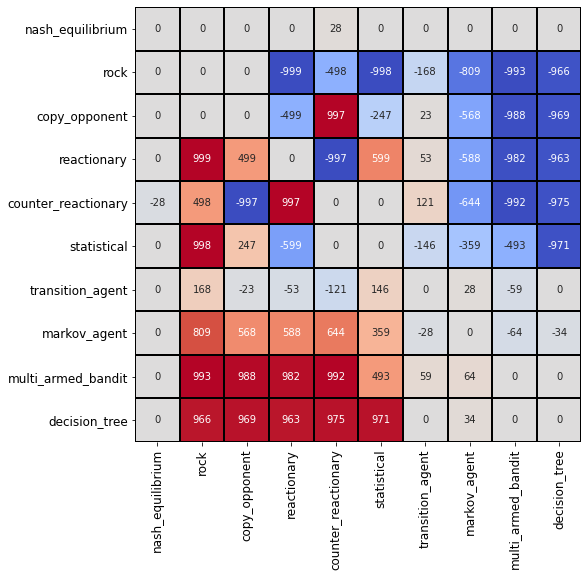

In [24]:
df_scores = pd.DataFrame(scores, index=list_names, columns=list_names)

plt.figure(figsize=(8, 8))
sns.heatmap(
    df_scores, annot=True, cbar=False, cmap='coolwarm', linewidths=1, linecolor='black', fmt="d"
)
plt.xticks(rotation=90, fontsize=12)
plt.yticks(fontsize=12);

<a id="102"></a>
<h2 style='background:#FBE338; border:0; color:black'><center>Test Your Own Agent<center><h2>


Set here your own agent

In [26]:
primes = (7,11,13,17,19,23,29,31,37,41,43)
period = random.choice(primes)
agent = random.choice(list_agents)

def all_the_agents(observation, configuration):
    global list_agents, primes, period, agent
    if observation.step < 3:
        return 0 #random.choice([0,1,2])
    if observation.step % period == 0:
        period = random.choice(primes)
        agent = random.choice(list_agents)
    action = agent(observation, configuration)
    if not action in [0,1,2]:
        return random.choice([0,1,2])
    else:
        return action   

In [25]:
voters = [
        copy_opponent, 
        reactionary, 
        counter_reactionary, 
        statistical, 
        otm,#transition_agent,
        markov_agent, 
        dtc#decision_tree
        ]

def polling_agent(observation, configuration):
    global voters
    list_actions = []
    # choose rock to start with
    if observation.step < 3:
        return 0

    for agent in voters:
        list_actions += [agent(observation, configuration)]

    r_votes = list_actions.count(0)
    p_votes = list_actions.count(1) 
    s_votes = list_actions.count(2)
    
    # give 5 votes to decision_tree agent:
    r_votes += 5*(list_actions[-1] == 0).astype(int)
    p_votes += 5*(list_actions[-1] == 1).astype(int) 
    s_votes += 5*(list_actions[-1] == 2).astype(int)

    return np.argmax([r_votes, p_votes, s_votes])


In [38]:
agent1 = all_the_agents
agent2 = dtc

configuration={"episodeSteps": 1000}
for ag in list_agents:
    rn = env.run([ag, all_the_agents])
    print (rn)
    #ev = evaluate("rps",  [ag, all_the_agents], configuration={"episodeSteps": 1000})
    #print (ev)

[[{'action': 0, 'reward': 0, 'info': {}, 'observation': {'remainingOverageTime': 60, 'step': 0}, 'status': 'ACTIVE'}, {'action': 0, 'reward': 0, 'info': {}, 'observation': {'remainingOverageTime': 60}, 'status': 'ACTIVE'}], [{'action': 0, 'reward': 0, 'info': {}, 'observation': {'remainingOverageTime': 60, 'step': 1, 'lastOpponentAction': 0}, 'status': 'ACTIVE'}, {'action': 0, 'reward': 0, 'info': {}, 'observation': {'remainingOverageTime': 60, 'lastOpponentAction': 0}, 'status': 'ACTIVE'}], [{'action': 1, 'reward': 1.0, 'info': {}, 'observation': {'remainingOverageTime': 60, 'step': 2, 'lastOpponentAction': 0}, 'status': 'ACTIVE'}, {'action': 0, 'reward': -1.0, 'info': {}, 'observation': {'remainingOverageTime': 60, 'lastOpponentAction': 1}, 'status': 'ACTIVE'}], [{'action': 2, 'reward': 0.0, 'info': {}, 'observation': {'remainingOverageTime': 60, 'step': 3, 'lastOpponentAction': 0}, 'status': 'ACTIVE'}, {'action': 0, 'reward': 0.0, 'info': {}, 'observation': {'remainingOverageTime': 

In [51]:
agent1 = polling_agent
agent2 = statistical

evaluate(
    "rps", 
    [agent1, agent2], 
    configuration={"episodeSteps": 1000}
        )
env.render(mode="ipython")

In [45]:
env.run([agent1, agent2])
env.render()#mode="ipython")

In [50]:
#for agent_1 in voters:

    #score =
evaluate(
        "rps", 
        [polling_agent, agent1], 
        configuration={"episodeSteps": 1000}
    )
    #print (score)

[[None, 1]]

In [ ]:
df_scores = pd.DataFrame(
    scores, 
    index=list_names, 
    columns=["your_agent"],
)


plt.figure(figsize=(2, 10))
sns.heatmap(
    df_scores, annot=True, cbar=False, 
    cmap="coolwarm", linewidths=1, linecolor="black", 
    fmt="d", vmin=-500, vmax=500,
)
plt.xticks(rotation=90, fontsize=15)
plt.yticks(rotation=360, fontsize=15);